# Simple Linear Regression using `keras`

As the [Keras Documentation](http://keras.io/) states, "Keras is a minimalist, highly modular neural networks library, written in Python and capable of running on top of either TensorFlow or Theano". In that regard, it's not really meant to be used to perform simple linear regression. However, in keeping with the theme of building up from simple linear regression, we're going to implement it using `keras`. 

## Computational Graphs for Simple Linear Regression 

As a reference, the computational graphs that we used to visualize the forward and backward propagation steps in solving our simple linear regression problem with gradient descent are as follows: 

### Forward Propagation 

<img src="../imgs/custom/simp_linear_comp_graph_forprop.png" width=400\>

### Backward Propagation 

<img src="../imgs/custom/simp_linear_comp_graph_backprop.png" width=400\>

### Performing Simple Linear Regression with Keras

As noted in it's documentation, `keras` can be run on top of either `tensorflow` or `theano`. This means that under the hood of our simple linear regression using `keras`, a similar version of the code that we wrote in our `theano` or `tensorflow` implementation is being run. By default, `keras` runs on `theano`, but by [adjusting our keras configuration file](http://keras.io/backend/#switching-from-one-backend-to-another), we can easily change that. For now, though, we'll just run it on `theano`. 

In [1]:
import numpy as np
from keras.layers import Input
from keras.layers.core import Dense
from keras.models import Model
from keras.optimizers import SGD
from datasets.general import gen_simple_linear
from utils.plotting import plot_errors
%matplotlib inline

Using Theano backend.


In [2]:
def get_keras_model(): 
    learning_rate = 0.1
    # 1. Specify a placeholder for the inputs. 
    xs = Input(shape=(1,))
    # 2. Define the equation that generates predictions. 
    ys = Dense(1, activation='linear')(xs)

    # 3. Define a `Model` object that will be used to train/learn the coefficients. 
    linear_model = Model(input=xs, output=ys)
    
    # 4. Define the optimizer and loss function used to train/learn the coefficients. 
    sgd = SGD(learning_rate)
    
    # 5. Compile the model (basically, build up the backpropagation steps)
    linear_model.compile(loss='mean_squared_error', optimizer=sgd)
    
    return linear_model

Despite the code looking pretty different from our prior implementations in `theano` and `tensorflow`, our `get_keras_model` function returns back what our `get_theano_graph` ([notebook 1c](https://github.com/sallamander/neural-networks-intro/blob/master/mini-books/shallow-neural-networks/01-simple-linear/1c_nn_th.ipynb)) and `get_tensorflow_graph` ([notebook 1d](https://github.com/sallamander/neural-networks-intro/blob/master/mini-books/shallow-neural-networks/01-simple-linear/1d_nn_tf.ipynb)) functions returned. It returns a set of computations that perform forward and backward propagation in order to solve a simple linear regression problem using gradient descent.

The most notable feature of our `get_keras_model` compared to our prior implementations is it's smaller code base, which makes sense given it's goal to be a "minimalist, highly modular neural networks library". Our forward propagation is defined in 2 steps, compared to the 5 steps it took with `theano` or `tensorflow`: 

* Step `1` is the `keras` way of generating a placeholder variable that will later be replaced with real data. The one piece of information we have to provide is the dimensionality of one of our input observations (e.g. how many features it has). With simple linear regression, we only have one feature. 
* Step `2` defines our linear regression equation, <img src="../imgs/equations/simp_linear.png" width=100 style="vertical-align: text-middle; display: inline-block; padding-top:0; margin-top:0;" \>. We'll get more into the details of how this `Dense` class works at a later point when we cover some of the terminology of neural networks. For now, just trust that it defines our simple linear regression equation. 

Our backward propagation step is defined in steps `4-5`: 

* Step `4` specifies exactly how to perform our gradient descent updates. Here, we'll use what we've used in all of our prior implementations - gradient descent with a learning rate of 0.1. As we'll see in later notebooks, there are a number of more complicated flavors of gradient descent that we also have the option to use.
* Step `5` tells `keras` to calculate the update rules for our coefficients, defining each of the steps necessary for doing so (including the calculating of all necessary derivatives). Here, we have to specify a `loss` as well as an `optimizer`. 
 The `optimizer` is what we discussed directly above - it specifies how to perform our gradient descent updates. The `loss` function specifies how we calculate the error, which up to this point has been using squared error. After defining both a `loss` and `optimizer`, `keras` has all of the pieces it needs to calculate the update rules for our coefficients, and to add those update steps into the graph that it will later run through. 

Step `3` builds a model object that we can later use to learn our coefficients. To instantiate it, we have to specify `input` as well as `output`. To finish building it and make it usable, we have to run `compile` on it like we did in step `5`. 

Let's now use our `keras` model to actually solve a linear regression problem...

Final Error: 9.167618053584903e-12


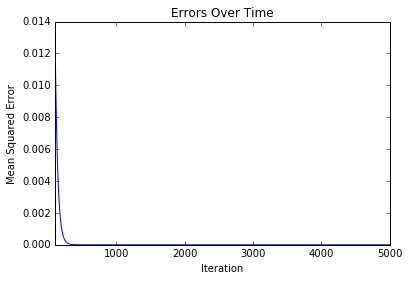

In [3]:
# Randomly generate a beta_0, beta_1, and number of observations, used to generate 
# fake data to fit. We need a minimum of 2 obs. 
true_beta_0, true_beta_1 = np.random.randint(2, 10, size=2) 
n_obs = np.random.randint(9500, 10500)

# Generate the data that follows a linear relationship specified 
# by true_beta_0 and true_beta_1.
xs, ys = gen_simple_linear(true_beta_0, true_beta_1, n_obs)

# Generate the keras model and print out the initial weights.
linear_model = get_keras_model()
init_weights = linear_model.get_weights()
init_beta_0, init_beta_1 = init_weights[1][0], init_weights[0][0][0]

# Learn the coefficients (perform iterations of forward and backward propagation)
linear_model.fit(xs, ys, nb_epoch=5000, verbose=0, batch_size=n_obs)
# The history attribute holds a history dictionary that we can use to access the
# loss (mean squared error) after each iteration. 
mean_squared_errors = linear_model.history.history['loss']
# Skip the first 100 values because it pulls the y-axis up quite a bit. 
plot_errors(mean_squared_errors, iterations=(100, 5000))
print("Final Error: {}".format(mean_squared_errors[-1]))

To run our `keras` model and learn the coefficients, we simply call `fit` on it, making sure to pass in our inputs and outputs (`xs` and `ys`). Here, we also use the `nb_epoch` argument to specify how many iterations of forward and backward propagation to perform over the entire data set (the default value for `nb_epoch` is 10), and `batch_size` to control how many observations the model looks at in each individual foward/backward propagation step (right now we want it to just look at all of them). We'll detail these parameters more later as we dive into neural networks.

Upon running our model, we can see that we are also able to solve our simple linear regression problem using `keras`, and that we again are able to obtain effectively zero mean squared error. 

We'll now move on to looking at multiple linear regression from a neural network perspective. In viewing it as a computational graph as well and coding it up using `numpy`, `theano`, `tensorflow`, and `keras`, we'll move one step closer to discussing true neural networks. 